In [1]:
%matplotlib inline

# Data analysis

In this notebook you will find:
- Necessary imports
- Participant age information
- Number of dyslexic parents
- Function to calculate the average erp per class (risk/no risk)
- Frequency domain features
- Connectivity with stimulus and without 

Note: Make sure you run the data analysis notebook before to have the right paths in the `metadata.csv`!

# Imports

Below are the necessary imports for this notebook. mne_connectivity still needs to be added to the environment. 

In [3]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

# Make sure that the 5 imports below are all installed using pip install ... 
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity
import pyvista 
import mayavi
import vtk

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
#import initialization_functions #library to import data
import epod_helper

The newest version of mne is necessary to run connectivity plots. If you don't have the latest version, uncomment and run the line below.

In [4]:
# pip install git+https://github.com/mne-tools/mne-python.git

## Load metadata

In the notebook `data_prep_eeg.ipynb` a csv-file `metadata.csv` is created. It is saved in the same folder as this notebook. The csv contains information about the participants and the corresponding eeg and epoch files. 

In [5]:
metadata = pd.read_csv('metadata.csv', sep = ',')

In [11]:
metadata = metadata[:1]

## Participant information

The value to classify will be whether the participant is at risk for dyslexia or not. The age distribution for both groups is plotted below.

count     1.0
mean     20.0
std       NaN
min      20.0
25%      20.0
50%      20.0
75%      20.0
max      20.0
Name: age_months, dtype: float64

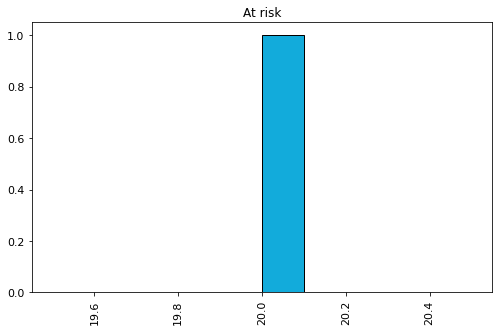

In [12]:
hist = metadata.hist(column='age_months',by='Group_AccToParents',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black')
metadata['age_months'].describe()

Count of the gender for both groups. 

In [13]:
metadata.groupby('Group_AccToParents')['sex'].value_counts()

Group_AccToParents  sex
At risk             m      1
Name: sex, dtype: int64

Count of whether the mom or dad is dyslexic or not. 

In [14]:
metadata.groupby('Group_AccToParents')['dyslexic_parent'].value_counts()

Group_AccToParents  dyslexic_parent
At risk             m                  1
Name: dyslexic_parent, dtype: int64

## ERP per group

This function is able to calculate the average erp for a specific condition. The function needs a dataframe like `metadata.csv` which contains the epoch files and the participants characteristics. It also needs as input the characteristic we are interested in and a single value of this characteristic. For example if we want to look at the average erp for the children who are at risk, the group will be the column (feature) containing the values at risk or control and the value will be 'at risk'. The function also needs the event dictionary in order to average the epochs over multiple participants. 

In [15]:
event_dictionary = epod_helper.event_dictionary

def data_analysis(dataframe, group, value, event_dictionary):
    epochs = []
    evoked_pp = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    evoked = hf.evoked_responses(epochs, event_dictionary)
    
    for i in range(len(evoked)):
        grand_avg = mne.grand_average(evoked[i])
        evoked_pp.append(grand_avg)
    
    grand_evoked = mne.grand_average(evoked_pp)
    
    return grand_evoked.plot(spatial_colors=True)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Identifying common channels ...
Identifying common channels ...


<ipython-input-15-c324b116ea20>:20: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  grand_evoked = mne.grand_average(evoked_pp)


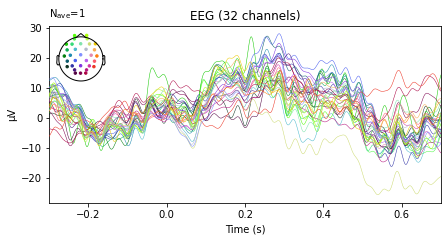

In [16]:
atrisk = data_analysis(metadata, group='Group_AccToParents', value = 'At risk', event_dictionary = epod_helper.event_dictionary)

In [17]:
control = data_analysis(metadata, group='Group_AccToParents', value = 'Control', event_dictionary = epod_helper.event_dictionary)

ValueError: Please pass a list of Evoked or AverageTFR objects.

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Identifying common channels ...
Identifying common channels ...


<ipython-input-15-c324b116ea20>:20: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  grand_evoked = mne.grand_average(evoked_pp)


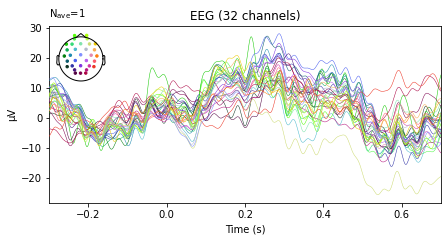

In [18]:
test_a = data_analysis(metadata, group='test', value = 'a', event_dictionary = epod_helper.event_dictionary)

In [19]:
test_b = data_analysis(metadata, group='test', value = 'b', event_dictionary = epod_helper.event_dictionary)

ValueError: Please pass a list of Evoked or AverageTFR objects.

## Connectivity 

In [20]:
dataframe = metadata
epochs = []
for index, file in dataframe.iterrows():
    print(f"Checking out file: {file['epoch_file']}")
    path = os.path.join(file['path_epoch'], file['epoch_file'])
    epoch = mne.read_epochs(path, preload=False)
    epochs.append(epoch)

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated


Computing eeg connectivity

In [24]:
def data_connectivity(dataframe, group, value):
    epochs = []
    dataframe = dataframe.loc[metadata[group] == value]
    
    for index, file in dataframe.iterrows():
        print(f"Checking out file: {file['epoch_file']}")
        path = os.path.join(file['path_epoch'], file['epoch_file'])
        epoch = mne.read_epochs(path, preload=False)
        epochs.append(epoch)
    
    epochs_con = mne.concatenate_epochs(epochs)
    
    fmin, fmax = 4., 9.
    sfreq = epochs_con.info['sfreq']  # the sampling frequency
    tmin = 0.0  # exclude the baseline period
    
    con = spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

    # Now, visualize the connectivity in 3D:
    
    return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(
        epochs_con, method='pli', mode='multitaper', fmin=fmin, fmax=fmax,
        faverage=True, tmin=tmin, mt_adaptive=False, n_jobs=1)

In [29]:
connectivityplot_atrisk, connections_atrisk = data_connectivity(metadata, group='Group_AccToParents', value = 'At risk')

Checking out file: 101a_epo.fif
Reading F:\Stage\ePODIUM\eegyolk\dyslexiaprediction_nadine\epochs\101a_epo.fif ...
    Found the data of interest:
        t =    -299.80 ...     700.20 ms
        0 CTF compensation matrices available
Not setting metadata
2266 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2266 events and 2049 original time points ...
Not setting metadata
2266 matching events found
Applying baseline correction (mode: mean)
0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.700s for estimation (1435 points)
    frequencies: 4.3Hz..8.6Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectiv

<ipython-input-24-5d638e64ba9f>:17: RuntimeWarning: There were no Annotations stored in <Epochs |  2266 events (all good), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~1.11 GB, data loaded,
 '1': 123
 '2': 333
 '3': 114
 '4': 114
 '5': 317
 '6': 104
 '7': 120
 '8': 320
 '9': 111
 '10': 130
 and 2 more events ...>, so metadata was not modified.
  con = spectral_connectivity_epochs(
<ipython-input-24-5d638e64ba9f>:17: RuntimeWarning: fmin=4.000 Hz corresponds to 2.803 < 5 cycles based on the epoch length 0.701 sec, need at least 1.250 sec epochs or fmin=7.136. Spectrum estimate will be unreliable.
  con = spectral_connectivity_epochs(


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing connectivity for epoch 215
    computing connectivity for epoch 216
    computing connectivity for epoch 217
    computing connectivity for epoch 218
    computing connectivity for epoch 219
    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing connectivity for epoch 228
    computing connectivity for epoch 229
    computing connectivity for epoch 230
    computing connectivity for epoch 231
    computing connectivity for epoch 232
    computing connectivity for epoch 233
    computing co

    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing connectivity for epoch 414
    computing connectivity for epoch 415
    computing connectivity for epoch 416
    computing connectivity for epoch 417
    computing connectivity for epoch 418
    computing connectivity for epoch 419
    computing connectivity for epoch 420
    computing connectivity for epoch 421
    computing connectivity for epoch 422
    computing connectivity for epoch 423
    computing connectivity for epoch 424
    computing connectivity for epoch 425
    computing connectivity for epoch 426
    computing connectivity for epoch 427
    computing connectivity for epoch 428
    computing connectivity for epoch 429
    computing connectivity for epoch 430
    computing connectivity for epoch 431
    computing connectivity for epoch 432
    computing connectivity for epoch 433
    computing co

    computing connectivity for epoch 610
    computing connectivity for epoch 611
    computing connectivity for epoch 612
    computing connectivity for epoch 613
    computing connectivity for epoch 614
    computing connectivity for epoch 615
    computing connectivity for epoch 616
    computing connectivity for epoch 617
    computing connectivity for epoch 618
    computing connectivity for epoch 619
    computing connectivity for epoch 620
    computing connectivity for epoch 621
    computing connectivity for epoch 622
    computing connectivity for epoch 623
    computing connectivity for epoch 624
    computing connectivity for epoch 625
    computing connectivity for epoch 626
    computing connectivity for epoch 627
    computing connectivity for epoch 628
    computing connectivity for epoch 629
    computing connectivity for epoch 630
    computing connectivity for epoch 631
    computing connectivity for epoch 632
    computing connectivity for epoch 633
    computing co

    computing connectivity for epoch 810
    computing connectivity for epoch 811
    computing connectivity for epoch 812
    computing connectivity for epoch 813
    computing connectivity for epoch 814
    computing connectivity for epoch 815
    computing connectivity for epoch 816
    computing connectivity for epoch 817
    computing connectivity for epoch 818
    computing connectivity for epoch 819
    computing connectivity for epoch 820
    computing connectivity for epoch 821
    computing connectivity for epoch 822
    computing connectivity for epoch 823
    computing connectivity for epoch 824
    computing connectivity for epoch 825
    computing connectivity for epoch 826
    computing connectivity for epoch 827
    computing connectivity for epoch 828
    computing connectivity for epoch 829
    computing connectivity for epoch 830
    computing connectivity for epoch 831
    computing connectivity for epoch 832
    computing connectivity for epoch 833
    computing co

    computing connectivity for epoch 1010
    computing connectivity for epoch 1011
    computing connectivity for epoch 1012
    computing connectivity for epoch 1013
    computing connectivity for epoch 1014
    computing connectivity for epoch 1015
    computing connectivity for epoch 1016
    computing connectivity for epoch 1017
    computing connectivity for epoch 1018
    computing connectivity for epoch 1019
    computing connectivity for epoch 1020
    computing connectivity for epoch 1021
    computing connectivity for epoch 1022
    computing connectivity for epoch 1023
    computing connectivity for epoch 1024
    computing connectivity for epoch 1025
    computing connectivity for epoch 1026
    computing connectivity for epoch 1027
    computing connectivity for epoch 1028
    computing connectivity for epoch 1029
    computing connectivity for epoch 1030
    computing connectivity for epoch 1031
    computing connectivity for epoch 1032
    computing connectivity for epo

    computing connectivity for epoch 1206
    computing connectivity for epoch 1207
    computing connectivity for epoch 1208
    computing connectivity for epoch 1209
    computing connectivity for epoch 1210
    computing connectivity for epoch 1211
    computing connectivity for epoch 1212
    computing connectivity for epoch 1213
    computing connectivity for epoch 1214
    computing connectivity for epoch 1215
    computing connectivity for epoch 1216
    computing connectivity for epoch 1217
    computing connectivity for epoch 1218
    computing connectivity for epoch 1219
    computing connectivity for epoch 1220
    computing connectivity for epoch 1221
    computing connectivity for epoch 1222
    computing connectivity for epoch 1223
    computing connectivity for epoch 1224
    computing connectivity for epoch 1225
    computing connectivity for epoch 1226
    computing connectivity for epoch 1227
    computing connectivity for epoch 1228
    computing connectivity for epo

    computing connectivity for epoch 1402
    computing connectivity for epoch 1403
    computing connectivity for epoch 1404
    computing connectivity for epoch 1405
    computing connectivity for epoch 1406
    computing connectivity for epoch 1407
    computing connectivity for epoch 1408
    computing connectivity for epoch 1409
    computing connectivity for epoch 1410
    computing connectivity for epoch 1411
    computing connectivity for epoch 1412
    computing connectivity for epoch 1413
    computing connectivity for epoch 1414
    computing connectivity for epoch 1415
    computing connectivity for epoch 1416
    computing connectivity for epoch 1417
    computing connectivity for epoch 1418
    computing connectivity for epoch 1419
    computing connectivity for epoch 1420
    computing connectivity for epoch 1421
    computing connectivity for epoch 1422
    computing connectivity for epoch 1423
    computing connectivity for epoch 1424
    computing connectivity for epo

    computing connectivity for epoch 1598
    computing connectivity for epoch 1599
    computing connectivity for epoch 1600
    computing connectivity for epoch 1601
    computing connectivity for epoch 1602
    computing connectivity for epoch 1603
    computing connectivity for epoch 1604
    computing connectivity for epoch 1605
    computing connectivity for epoch 1606
    computing connectivity for epoch 1607
    computing connectivity for epoch 1608
    computing connectivity for epoch 1609
    computing connectivity for epoch 1610
    computing connectivity for epoch 1611
    computing connectivity for epoch 1612
    computing connectivity for epoch 1613
    computing connectivity for epoch 1614
    computing connectivity for epoch 1615
    computing connectivity for epoch 1616
    computing connectivity for epoch 1617
    computing connectivity for epoch 1618
    computing connectivity for epoch 1619
    computing connectivity for epoch 1620
    computing connectivity for epo

    computing connectivity for epoch 1794
    computing connectivity for epoch 1795
    computing connectivity for epoch 1796
    computing connectivity for epoch 1797
    computing connectivity for epoch 1798
    computing connectivity for epoch 1799
    computing connectivity for epoch 1800
    computing connectivity for epoch 1801
    computing connectivity for epoch 1802
    computing connectivity for epoch 1803
    computing connectivity for epoch 1804
    computing connectivity for epoch 1805
    computing connectivity for epoch 1806
    computing connectivity for epoch 1807
    computing connectivity for epoch 1808
    computing connectivity for epoch 1809
    computing connectivity for epoch 1810
    computing connectivity for epoch 1811
    computing connectivity for epoch 1812
    computing connectivity for epoch 1813
    computing connectivity for epoch 1814
    computing connectivity for epoch 1815
    computing connectivity for epoch 1816
    computing connectivity for epo

    computing connectivity for epoch 1990
    computing connectivity for epoch 1991
    computing connectivity for epoch 1992
    computing connectivity for epoch 1993
    computing connectivity for epoch 1994
    computing connectivity for epoch 1995
    computing connectivity for epoch 1996
    computing connectivity for epoch 1997
    computing connectivity for epoch 1998
    computing connectivity for epoch 1999
    computing connectivity for epoch 2000
    computing connectivity for epoch 2001
    computing connectivity for epoch 2002
    computing connectivity for epoch 2003
    computing connectivity for epoch 2004
    computing connectivity for epoch 2005
    computing connectivity for epoch 2006
    computing connectivity for epoch 2007
    computing connectivity for epoch 2008
    computing connectivity for epoch 2009
    computing connectivity for epoch 2010
    computing connectivity for epoch 2011
    computing connectivity for epoch 2012
    computing connectivity for epo

    computing connectivity for epoch 2186
    computing connectivity for epoch 2187
    computing connectivity for epoch 2188
    computing connectivity for epoch 2189
    computing connectivity for epoch 2190
    computing connectivity for epoch 2191
    computing connectivity for epoch 2192
    computing connectivity for epoch 2193
    computing connectivity for epoch 2194
    computing connectivity for epoch 2195
    computing connectivity for epoch 2196
    computing connectivity for epoch 2197
    computing connectivity for epoch 2198
    computing connectivity for epoch 2199
    computing connectivity for epoch 2200
    computing connectivity for epoch 2201
    computing connectivity for epoch 2202
    computing connectivity for epoch 2203
    computing connectivity for epoch 2204
    computing connectivity for epoch 2205
    computing connectivity for epoch 2206
    computing connectivity for epoch 2207
    computing connectivity for epoch 2208
    computing connectivity for epo

Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 496 connections
    using t=0.000s..0.700s for estimation (1435 points)
    frequencies: 4.3Hz..8.6Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity

<ipython-input-24-5d638e64ba9f>:23: RuntimeWarning: There were no Annotations stored in <Epochs |  2266 events (all good), -0.299805 - 0.700195 sec, baseline -0.299805 – 0 sec, ~1.11 GB, data loaded,
 '1': 123
 '2': 333
 '3': 114
 '4': 114
 '5': 317
 '6': 104
 '7': 120
 '8': 320
 '9': 111
 '10': 130
 and 2 more events ...>, so metadata was not modified.
  return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(
<ipython-input-24-5d638e64ba9f>:23: RuntimeWarning: fmin=4.000 Hz corresponds to 2.803 < 5 cycles based on the epoch length 0.701 sec, need at least 1.250 sec epochs or fmin=7.136. Spectrum estimate will be unreliable.
  return plot_sensors_connectivity(epochs_con.info, con.get_data(output='dense')[:, :, 0]), spectral_connectivity_epochs(


    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42


    computing connectivity for epoch 220
    computing connectivity for epoch 221
    computing connectivity for epoch 222
    computing connectivity for epoch 223
    computing connectivity for epoch 224
    computing connectivity for epoch 225
    computing connectivity for epoch 226
    computing connectivity for epoch 227
    computing connectivity for epoch 228
    computing connectivity for epoch 229
    computing connectivity for epoch 230
    computing connectivity for epoch 231
    computing connectivity for epoch 232
    computing connectivity for epoch 233
    computing connectivity for epoch 234
    computing connectivity for epoch 235
    computing connectivity for epoch 236
    computing connectivity for epoch 237
    computing connectivity for epoch 238
    computing connectivity for epoch 239
    computing connectivity for epoch 240
    computing connectivity for epoch 241
    computing connectivity for epoch 242
    computing connectivity for epoch 243
    computing co

    computing connectivity for epoch 420
    computing connectivity for epoch 421
    computing connectivity for epoch 422
    computing connectivity for epoch 423
    computing connectivity for epoch 424
    computing connectivity for epoch 425
    computing connectivity for epoch 426
    computing connectivity for epoch 427
    computing connectivity for epoch 428
    computing connectivity for epoch 429
    computing connectivity for epoch 430
    computing connectivity for epoch 431
    computing connectivity for epoch 432
    computing connectivity for epoch 433
    computing connectivity for epoch 434
    computing connectivity for epoch 435
    computing connectivity for epoch 436
    computing connectivity for epoch 437
    computing connectivity for epoch 438
    computing connectivity for epoch 439
    computing connectivity for epoch 440
    computing connectivity for epoch 441
    computing connectivity for epoch 442
    computing connectivity for epoch 443
    computing co

    computing connectivity for epoch 620
    computing connectivity for epoch 621
    computing connectivity for epoch 622
    computing connectivity for epoch 623
    computing connectivity for epoch 624
    computing connectivity for epoch 625
    computing connectivity for epoch 626
    computing connectivity for epoch 627
    computing connectivity for epoch 628
    computing connectivity for epoch 629
    computing connectivity for epoch 630
    computing connectivity for epoch 631
    computing connectivity for epoch 632
    computing connectivity for epoch 633
    computing connectivity for epoch 634
    computing connectivity for epoch 635
    computing connectivity for epoch 636
    computing connectivity for epoch 637
    computing connectivity for epoch 638
    computing connectivity for epoch 639
    computing connectivity for epoch 640
    computing connectivity for epoch 641
    computing connectivity for epoch 642
    computing connectivity for epoch 643
    computing co

    computing connectivity for epoch 820
    computing connectivity for epoch 821
    computing connectivity for epoch 822
    computing connectivity for epoch 823
    computing connectivity for epoch 824
    computing connectivity for epoch 825
    computing connectivity for epoch 826
    computing connectivity for epoch 827
    computing connectivity for epoch 828
    computing connectivity for epoch 829
    computing connectivity for epoch 830
    computing connectivity for epoch 831
    computing connectivity for epoch 832
    computing connectivity for epoch 833
    computing connectivity for epoch 834
    computing connectivity for epoch 835
    computing connectivity for epoch 836
    computing connectivity for epoch 837
    computing connectivity for epoch 838
    computing connectivity for epoch 839
    computing connectivity for epoch 840
    computing connectivity for epoch 841
    computing connectivity for epoch 842
    computing connectivity for epoch 843
    computing co

    computing connectivity for epoch 1020
    computing connectivity for epoch 1021
    computing connectivity for epoch 1022
    computing connectivity for epoch 1023
    computing connectivity for epoch 1024
    computing connectivity for epoch 1025
    computing connectivity for epoch 1026
    computing connectivity for epoch 1027
    computing connectivity for epoch 1028
    computing connectivity for epoch 1029
    computing connectivity for epoch 1030
    computing connectivity for epoch 1031
    computing connectivity for epoch 1032
    computing connectivity for epoch 1033
    computing connectivity for epoch 1034
    computing connectivity for epoch 1035
    computing connectivity for epoch 1036
    computing connectivity for epoch 1037
    computing connectivity for epoch 1038
    computing connectivity for epoch 1039
    computing connectivity for epoch 1040
    computing connectivity for epoch 1041
    computing connectivity for epoch 1042
    computing connectivity for epo

    computing connectivity for epoch 1216
    computing connectivity for epoch 1217
    computing connectivity for epoch 1218
    computing connectivity for epoch 1219
    computing connectivity for epoch 1220
    computing connectivity for epoch 1221
    computing connectivity for epoch 1222
    computing connectivity for epoch 1223
    computing connectivity for epoch 1224
    computing connectivity for epoch 1225
    computing connectivity for epoch 1226
    computing connectivity for epoch 1227
    computing connectivity for epoch 1228
    computing connectivity for epoch 1229
    computing connectivity for epoch 1230
    computing connectivity for epoch 1231
    computing connectivity for epoch 1232
    computing connectivity for epoch 1233
    computing connectivity for epoch 1234
    computing connectivity for epoch 1235
    computing connectivity for epoch 1236
    computing connectivity for epoch 1237
    computing connectivity for epoch 1238
    computing connectivity for epo

    computing connectivity for epoch 1412
    computing connectivity for epoch 1413
    computing connectivity for epoch 1414
    computing connectivity for epoch 1415
    computing connectivity for epoch 1416
    computing connectivity for epoch 1417
    computing connectivity for epoch 1418
    computing connectivity for epoch 1419
    computing connectivity for epoch 1420
    computing connectivity for epoch 1421
    computing connectivity for epoch 1422
    computing connectivity for epoch 1423
    computing connectivity for epoch 1424
    computing connectivity for epoch 1425
    computing connectivity for epoch 1426
    computing connectivity for epoch 1427
    computing connectivity for epoch 1428
    computing connectivity for epoch 1429
    computing connectivity for epoch 1430
    computing connectivity for epoch 1431
    computing connectivity for epoch 1432
    computing connectivity for epoch 1433
    computing connectivity for epoch 1434
    computing connectivity for epo

    computing connectivity for epoch 1608
    computing connectivity for epoch 1609
    computing connectivity for epoch 1610
    computing connectivity for epoch 1611
    computing connectivity for epoch 1612
    computing connectivity for epoch 1613
    computing connectivity for epoch 1614
    computing connectivity for epoch 1615
    computing connectivity for epoch 1616
    computing connectivity for epoch 1617
    computing connectivity for epoch 1618
    computing connectivity for epoch 1619
    computing connectivity for epoch 1620
    computing connectivity for epoch 1621
    computing connectivity for epoch 1622
    computing connectivity for epoch 1623
    computing connectivity for epoch 1624
    computing connectivity for epoch 1625
    computing connectivity for epoch 1626
    computing connectivity for epoch 1627
    computing connectivity for epoch 1628
    computing connectivity for epoch 1629
    computing connectivity for epoch 1630
    computing connectivity for epo

    computing connectivity for epoch 1804
    computing connectivity for epoch 1805
    computing connectivity for epoch 1806
    computing connectivity for epoch 1807
    computing connectivity for epoch 1808
    computing connectivity for epoch 1809
    computing connectivity for epoch 1810
    computing connectivity for epoch 1811
    computing connectivity for epoch 1812
    computing connectivity for epoch 1813
    computing connectivity for epoch 1814
    computing connectivity for epoch 1815
    computing connectivity for epoch 1816
    computing connectivity for epoch 1817
    computing connectivity for epoch 1818
    computing connectivity for epoch 1819
    computing connectivity for epoch 1820
    computing connectivity for epoch 1821
    computing connectivity for epoch 1822
    computing connectivity for epoch 1823
    computing connectivity for epoch 1824
    computing connectivity for epoch 1825
    computing connectivity for epoch 1826
    computing connectivity for epo

    computing connectivity for epoch 2000
    computing connectivity for epoch 2001
    computing connectivity for epoch 2002
    computing connectivity for epoch 2003
    computing connectivity for epoch 2004
    computing connectivity for epoch 2005
    computing connectivity for epoch 2006
    computing connectivity for epoch 2007
    computing connectivity for epoch 2008
    computing connectivity for epoch 2009
    computing connectivity for epoch 2010
    computing connectivity for epoch 2011
    computing connectivity for epoch 2012
    computing connectivity for epoch 2013
    computing connectivity for epoch 2014
    computing connectivity for epoch 2015
    computing connectivity for epoch 2016
    computing connectivity for epoch 2017
    computing connectivity for epoch 2018
    computing connectivity for epoch 2019
    computing connectivity for epoch 2020
    computing connectivity for epoch 2021
    computing connectivity for epoch 2022
    computing connectivity for epo

    computing connectivity for epoch 2196
    computing connectivity for epoch 2197
    computing connectivity for epoch 2198
    computing connectivity for epoch 2199
    computing connectivity for epoch 2200
    computing connectivity for epoch 2201
    computing connectivity for epoch 2202
    computing connectivity for epoch 2203
    computing connectivity for epoch 2204
    computing connectivity for epoch 2205
    computing connectivity for epoch 2206
    computing connectivity for epoch 2207
    computing connectivity for epoch 2208
    computing connectivity for epoch 2209
    computing connectivity for epoch 2210
    computing connectivity for epoch 2211
    computing connectivity for epoch 2212
    computing connectivity for epoch 2213
    computing connectivity for epoch 2214
    computing connectivity for epoch 2215
    computing connectivity for epoch 2216
    computing connectivity for epoch 2217
    computing connectivity for epoch 2218
    computing connectivity for epo

In [30]:
connections_atrisk = connections_atrisk.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_atrisk)
matrix

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.190203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.086275,0.038614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.242277,0.177405,0.117387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.183142,0.203663,0.144748,0.185349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,0.147176,0.118711,0.115181,0.081421,0.058252,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,0.057149,0.047882,0.018535,0.026699,0.021624,0.058694,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,0.099515,0.101721,0.088482,0.082745,0.010150,0.028906,0.035746,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,0.075243,0.070388,0.083186,0.040159,0.020962,0.003972,0.019197,0.063107,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.046337,0.029126,0.032215,0.015004,0.026037,0.029568,0.027582,0.055825,0.022286,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [32]:
connectivityplot_control, connections_control = data_connectivity(metadata, group='Group_AccToParents', value = 'Control')

IndexError: list index out of range

In [ ]:
connections_control = connections_control.get_data(output='dense')[:, :, 0]
matrix = pd.DataFrame(connections_control)
matrix